# *Feature Selection* e *Feature Importance*

Fontes da aula de hoje:

1. Várias páginas da documentação da ``scikit-learn``
2. Várias páginas aleatórias da *Web*
3. Várias coisas aleatórias da cabeça do professor

# Introdução

## Nosso problema de interesse

Dados $D = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$, a tarefa de classificação consiste em encontrar um modelo $f$ que aprenda dos vetores de características os rótulos.

Há dois requisitos principais:

1. Se $(\mathbf{x}, y) \in D$, então $f(\mathbf{x}) = y$ com alta probabilidade.

2. A função aprendida deve ser **generalizável**. Se um novo $\mathbf{x}$ não pertencente ao conjunto $D$ for observado, deseja-se também que $f(\mathbf{x})$ seja o rótulo correto de $\mathbf{x}$ com alta probabilidade.

## Perguntas de hoje

- Todas as características do vetor $\mathbf{x}$ são (igualmente) importantes em um problema de classificação?
- Quais são as características mais importantes?
- É possível remover algumas características e preservar o desempenho do classificador?
- Como mensurar o efeito da variação de uma característica na saída do modelo?

## Abordagem

- Visualizações básicas
- Técnicas para computar importância de características
- Técnicas para selecionar características mais importantes
- SHAP (*SHapley Additive exPlanations*) -- Interpretação

# Conjunto de dados de exemplo

Considere o conjunto de dados de exemplo apresentado abaixo.

Cada item representa um conjunto de características de nódulos:
- Classe 1: o nódulo é benigno
- Classe 0: o nódulo é maligno

In [ ]:
from sklearn.datasets import load_breast_cancer

bc = load_breast_cancer(as_frame = True)
X, y = bc.data, bc.target

print(bc.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

# Visualizações

Uma maneira simples para entender a importância de cada característica em um problema de classificação é fazer o gráfico da distribuição de cada variável para cada classe.

A seguir, tem-se a aplicação dessa ideia para o conjunto de dados de exemplo.

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=figsize)


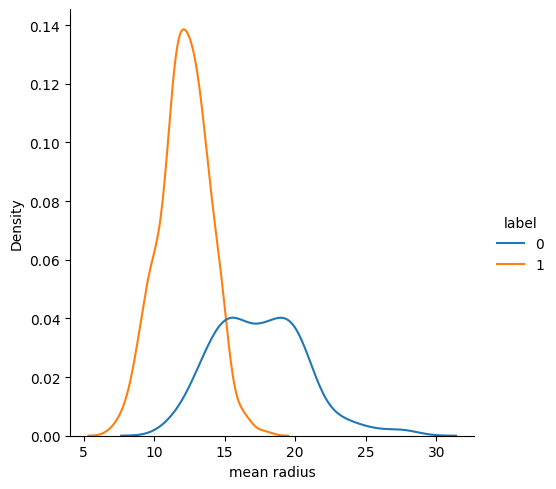

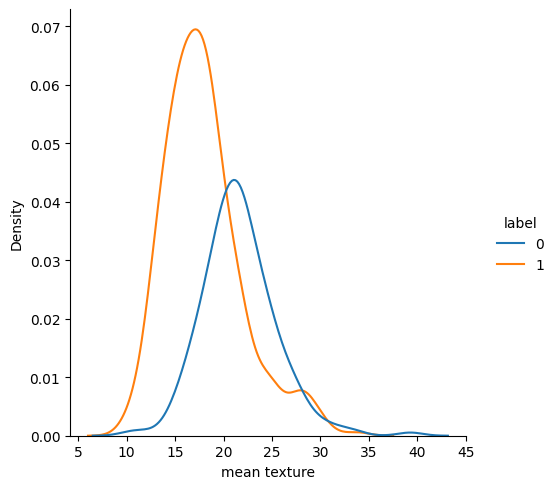

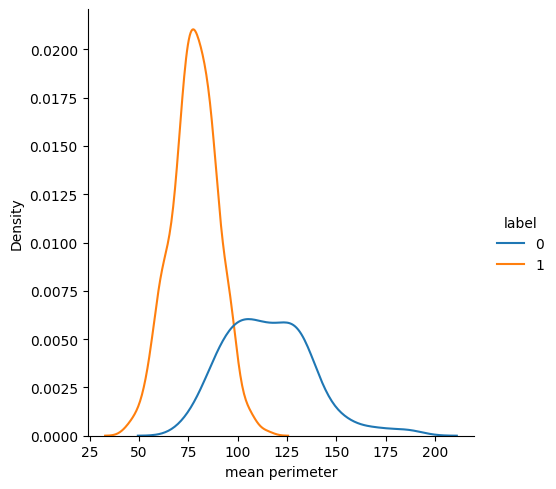

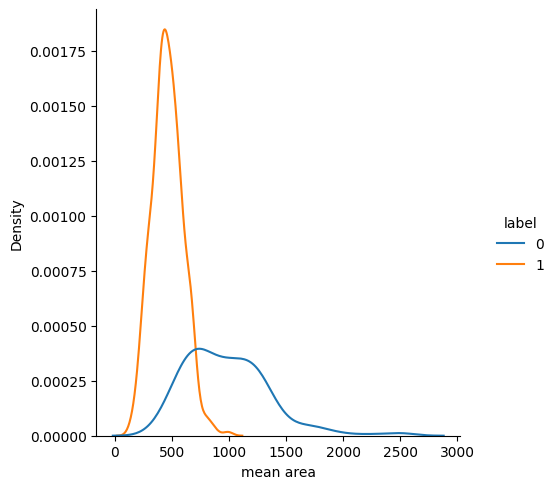

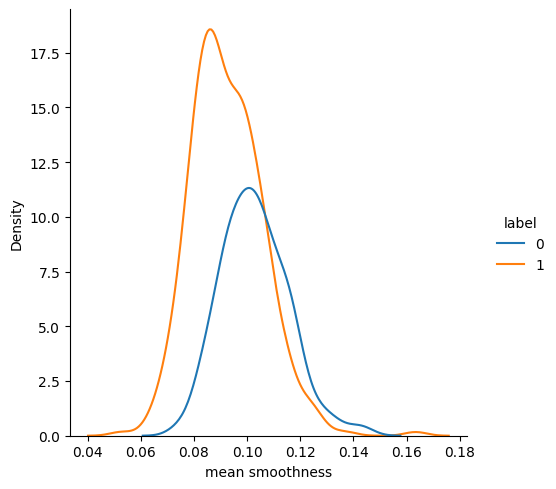

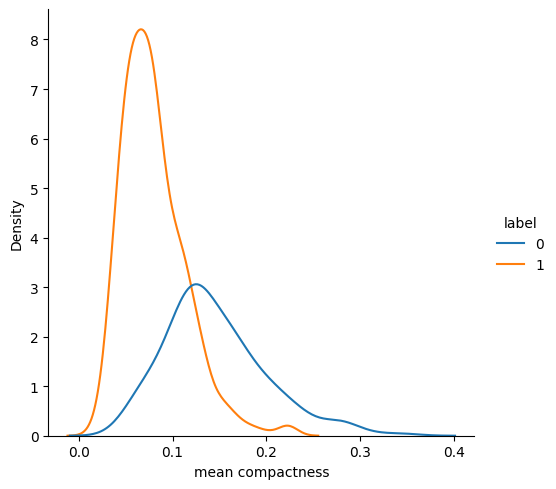

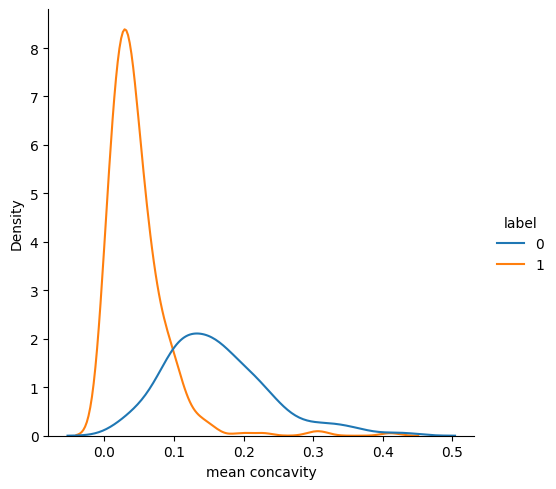

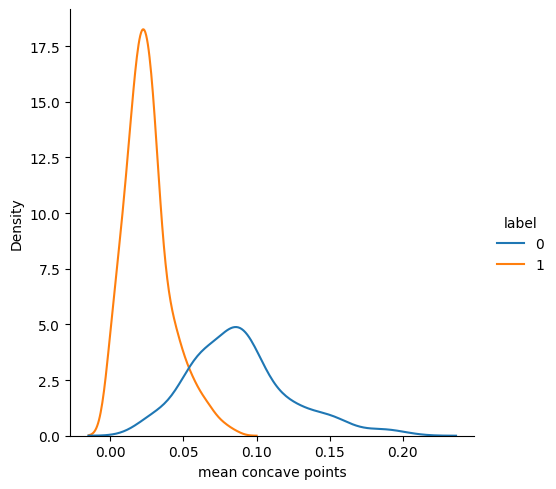

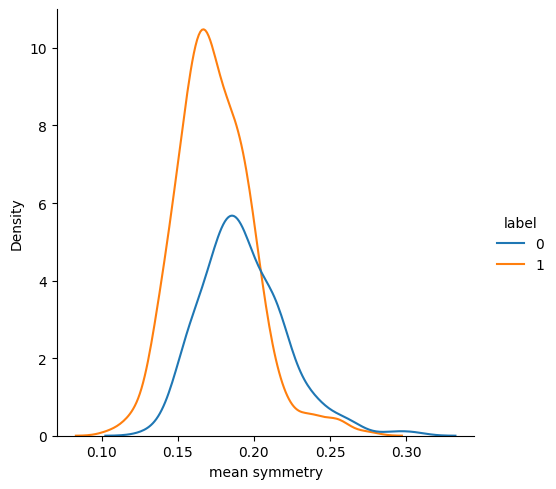

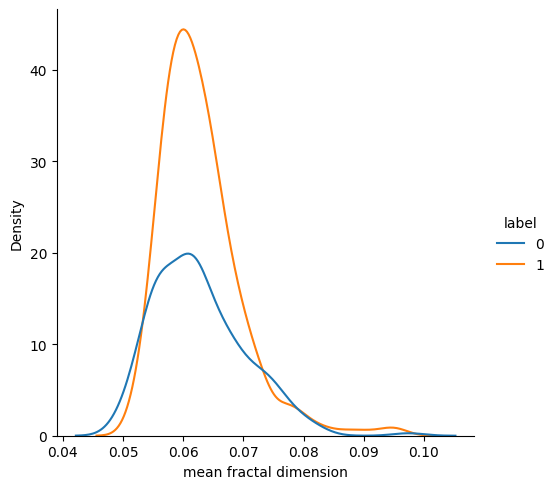

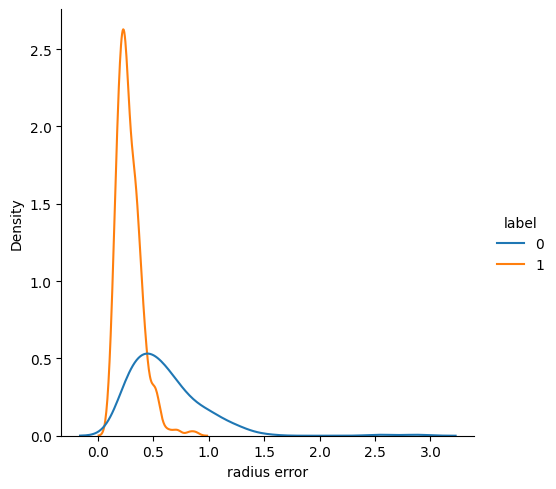

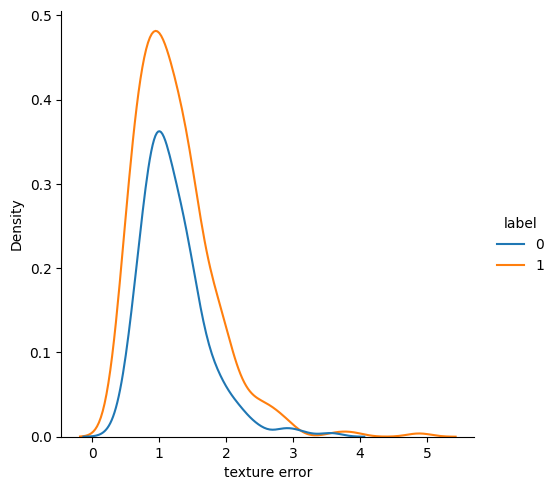

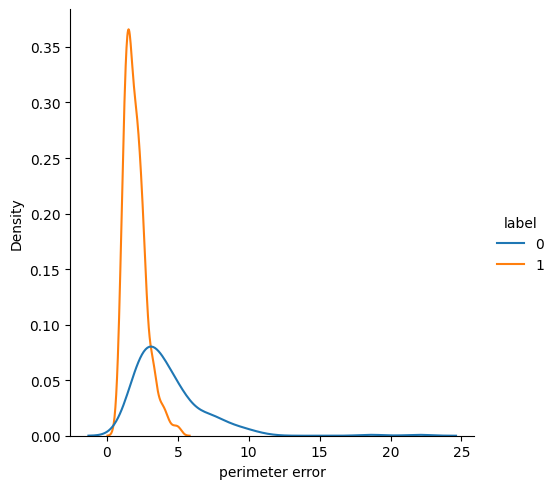

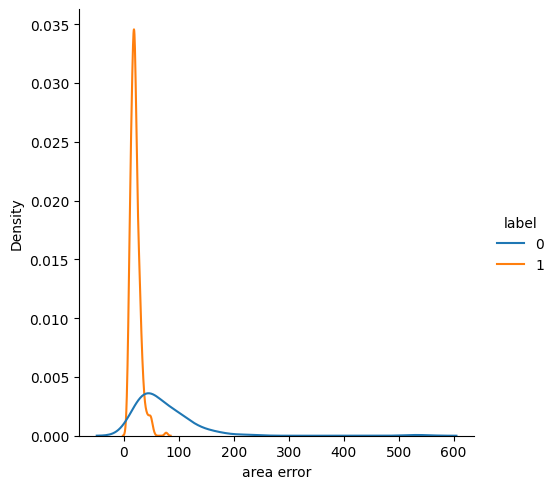

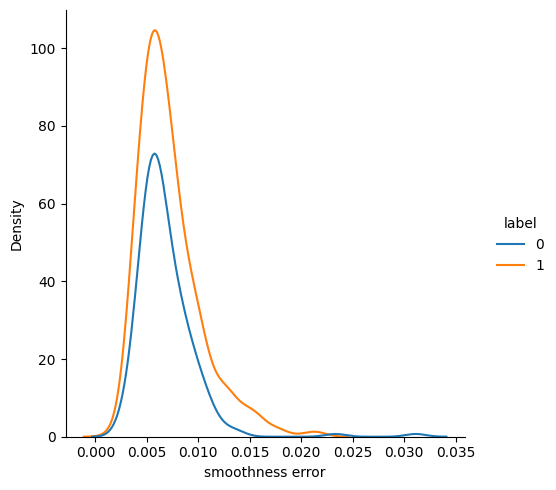

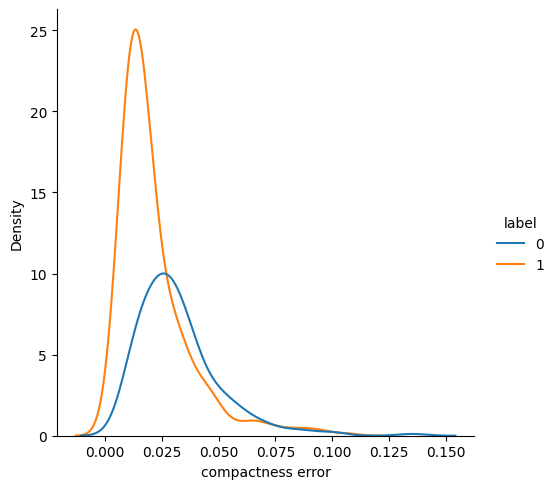

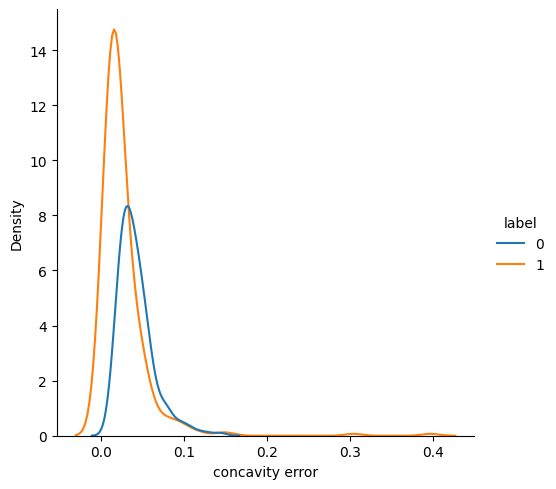

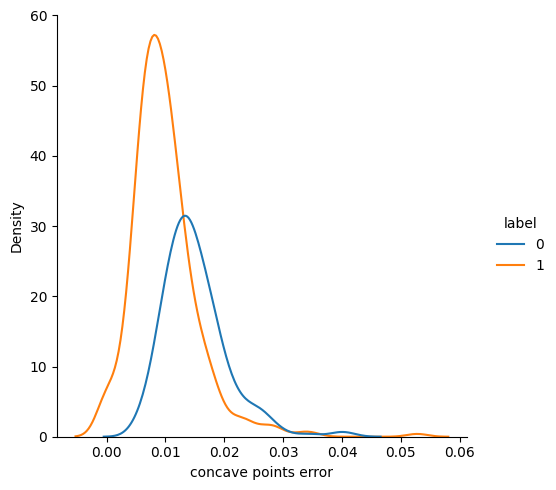

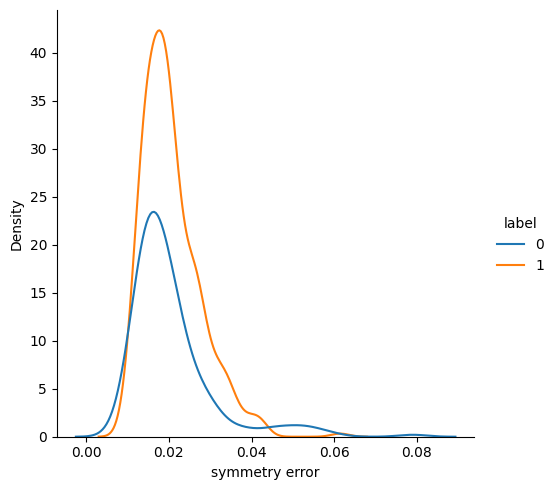

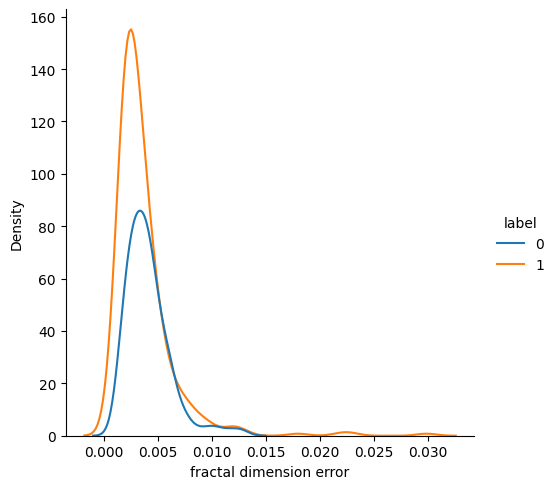

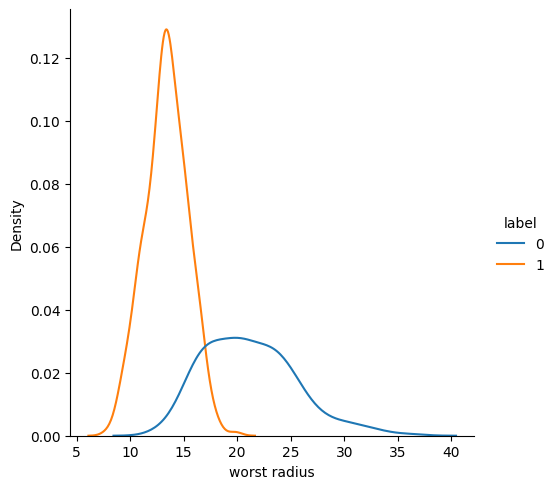

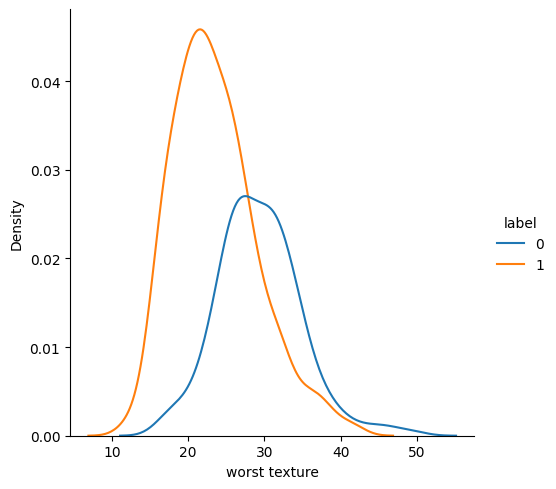

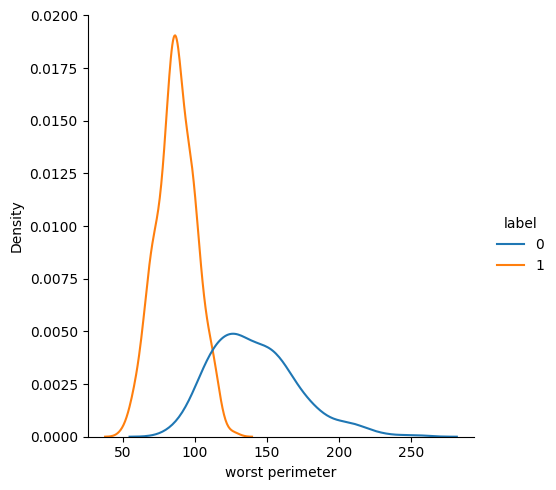

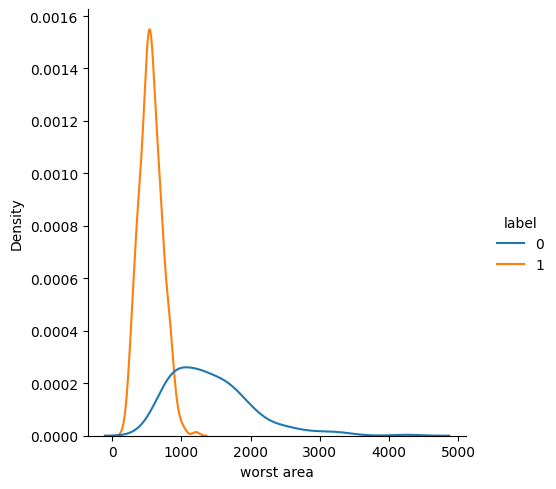

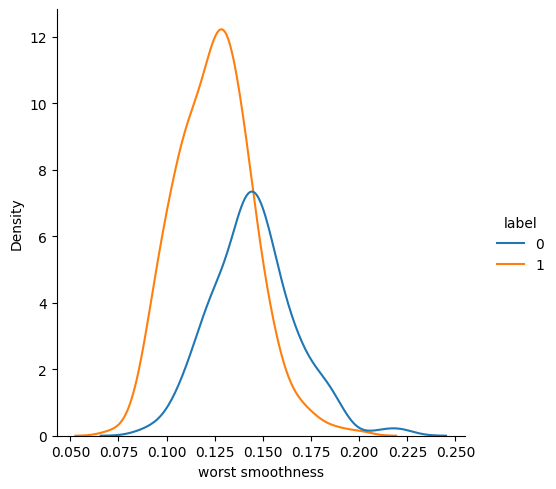

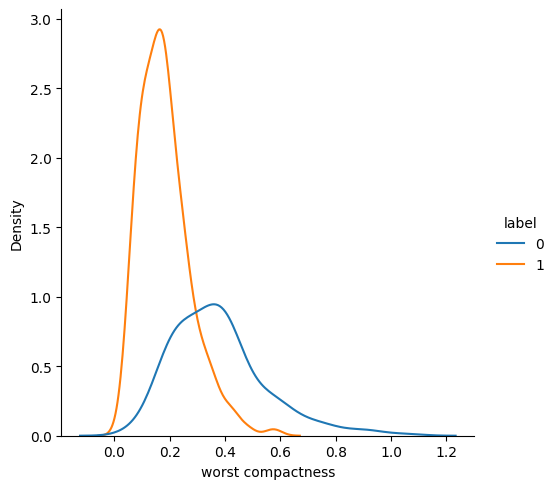

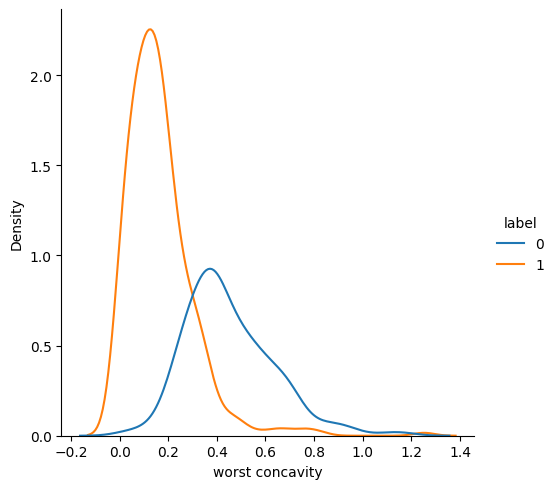

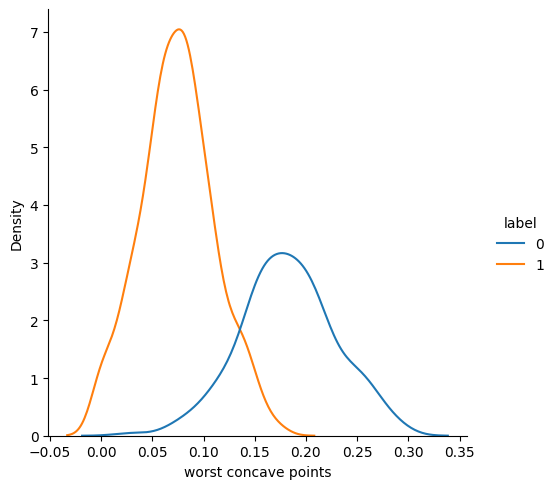

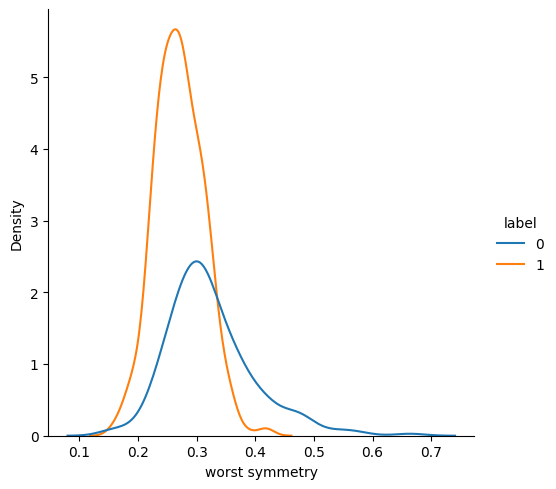

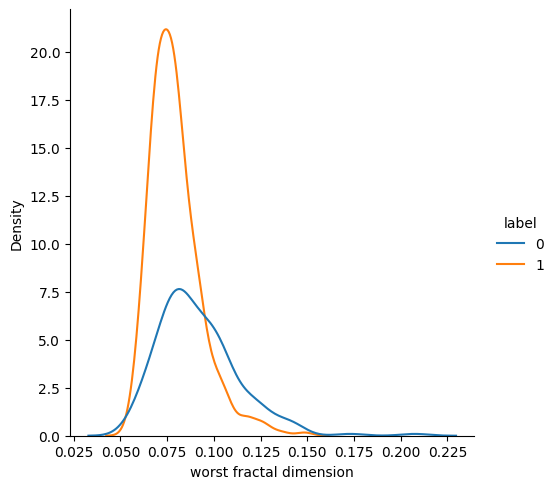

In [ ]:
import seaborn as sns

df = X.copy()
df['label'] = y

for feature in X.columns:
  sns.displot(df, x = feature, hue = 'label', kind = 'kde');


# Seleção de Características (*Feature Selection*)

## Abordagem univariada

Há várias abordagens para quantificar, individualmente, a importância de uma característica para um problema de classificação.

Isso pode ser feito de forma a considerar:
- Apenas o conjunto de dados de treinamento
- O conjunto de dados de treinamento e um classificador treinado (funciona apenas em alguns casos específicos)

### Informação Mútua

Uma forma clássica de mensurar a importância de características em um problema de classificação é usando o conceito de informação mútua.

#### Definição

Dadas duas variáveis aleatórias $X$ e $Y$, a informação mútua entre elas (denotada por $I(X; Y)$) mede a dependência mútua entre as duas variáveis.

Em outras palavras, $I(X; Y)$ representa a quantidade de informação que pode ser obtida sobre uma variável ao se observar a outra.

Fonte: [Wikipedia](https://en.wikipedia.org/wiki/Mutual_information).

A definição formal é ligeiramente complicada. No entanto, a informação mútua também pode ser escrita em função do conceito de entropia. Tem-se:

$$I(X; Y) = H(X) - H(X|Y),$$

onde:
- $H(X)$ é a entropia da variável aleatória $X$
- $H(X|Y)$ é a entropia condicional de $X$ dado $Y$

Lembrem, o conceito de entropia está relacionado à **quantidade de informação** necessária para descrever uma variável aleatória. Quanto maior a **incerteza** de uma variável, maior é sua entropia.

Logo (Informalmente):
- $H(X)$ representa a incerteza de $X$
- $H(X|Y)$ representa a incerteza de $X$ dado que o valor de $Y$ é conhecido

Logo, para que $I(X;Y)$ tenha um valor alto, é necessário que a incerteza de $X$ caia significativamente quando a variável $Y$ tem seu valor fixado. Em outras palavras, é necessário que $X$ tenha forte dependência em $Y$.

#### Exemplo

No mundo de classificação, podemos calcular a informação mútua entre nossa variável alvo ($y$ -- rótulos) e as características.

Quanto maior forem os valores observados, maior a importância de considerar a característica no modelo de classificação.

A Figura abaixo reporta os valores de informação mútua para as características  do conjunto de dados de exemplo.

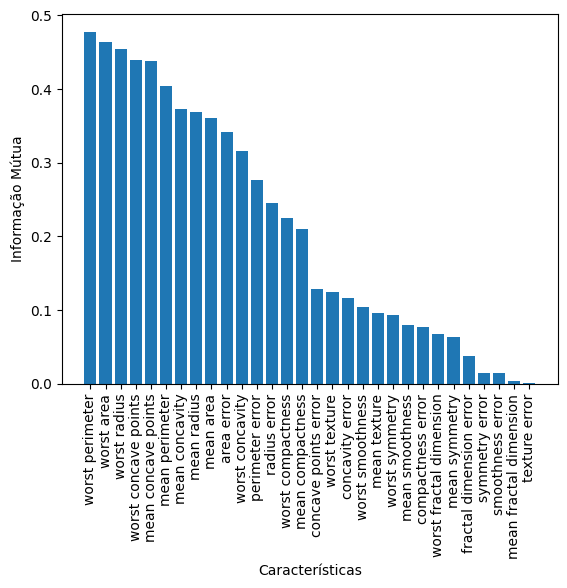

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y)
order = np.argsort(mi)[::-1]

plt.bar(X.columns[order], mi[order])
plt.ylabel('Informação Mútua')
plt.xlabel('Características')
plt.xticks(rotation=90);

#### Escolhendo as $k$ características mais importantes

Dado um limite $k$ de características que podem ser utlizadas no modelo, uma estratégia imediata é escolher as $k$ características com maior informação mútua.

A biblioteca `scikit-learn` possui uma classe para realizar tal tarefa. Veja o exemplo abaixo.

In [ ]:
from sklearn.feature_selection import SelectKBest

ms = SelectKBest(score_func = mutual_info_classif, k = 5)
ms.fit(X, y);

In [ ]:
ms.set_output(transform = 'pandas')
ms.transform(X)

,mean concave points,worst radius,worst perimeter,worst area,worst concave points
0,0.14710,25.380,184.60,2019.0,0.2654
1,0.07017,24.990,158.80,1956.0,0.1860
2,0.12790,23.570,152.50,1709.0,0.2430
3,0.10520,14.910,98.87,567.7,0.2575
4,0.10430,22.540,152.20,1575.0,0.1625
...,...,...,...,...,...
564,0.13890,25.450,166.10,2027.0,0.2216
565,0.09791,23.690,155.00,1731.0,0.1628
566,0.05302,18.980,126.70,1124.0,0.1418
567,0.15200,25.740,184.60,1821.0,0.2650


#### Pergunta

Faz sentido escolher $k$ características de forma independente?

Considere o exemplo abaixo.

In [ ]:
Z = X.copy()

Z['A'] = 2 * X['worst perimeter']
Z['B'] = X['worst perimeter'] + X['worst area']

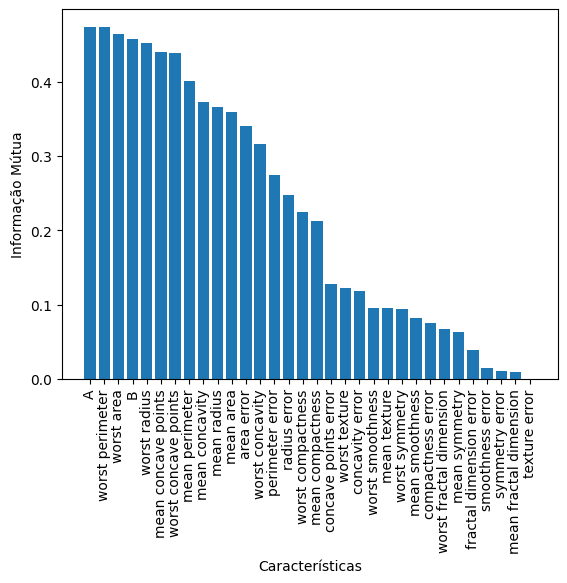

In [ ]:
mi = mutual_info_classif(Z, y)

order = np.argsort(mi)[::-1]
plt.bar(Z.columns[order], mi[order])
plt.ylabel('Informação Mútua')
plt.xlabel('Características')
plt.xticks(rotation=90);

O resultado acima ainda faz sentido, mas veja que as novas características computadas não adicionam **nova** informação ao modelo.

Assim, escolher as $k$ melhores características individualmente pode não ser a melhor abordagem.

## Importância baseada em modelos

Alguns classificadores permitem, de forma natural o cômputo da importância de características.

Um exemplo clássico nesse sentido é o classificador *Random Forest*.

Para cada árvore da floresta é calculado o quanto cada característica contribui para a elevação da pureza dos nós filhos durante construção da árvore.
Posteriormente, toma-se a média dos valores observados para cada uma das características.

Veja o exemplo abaixo para o conjunto de dados de exemplo.

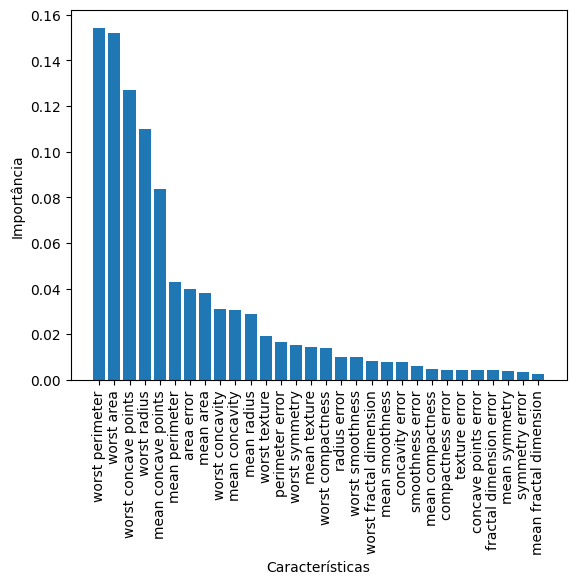

In [ ]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
model.fit(X, y)

importances = model.feature_importances_
order = np.argsort(importances)[::-1]

plt.bar(X.columns[order], importances[order])
plt.ylabel('Importância')
plt.xlabel('Características')
plt.xticks(rotation=90);

**Warning:** veja nesse caso que estamos calculando a importância da característica para o modelo!

## Abordagem multivariada

Dado um inteiro $k$ e um problema de classificação, qual o melhor conjunto $S$, de tamanho $k$, de características?

Em outras palavras, se só pudermos treinar um modelo em $k$ características, quais deveríamos escolher?

Nos exemplos acima, vimos que fazer uma escolha com base nas importâncias individuais não é uma abordagem adequada.

Uma escolha ótima torna-se, pelo que se sabe até o momento, intratável, uma vez que existem ${d \choose k}$ subconjuntos de tamanho $k$ para um total de $d$ características.

Há dois conjuntos clássicos de heurísticas para abordar o problema:
1. Eliminação Recursiva de Características (RFE -- *Recursive Feature Elimination*);
2. Seleção Sequencial de Características (SFE -- *Sequential Feature Selection*).

O primeiro funciona apenas em um contexto mais restrito/simples. O segundo conjunto é de propósito mais geral, o qual vamos explorar em mais detalhes.

### Seleção Sequencial de Características

**Entrada**

- Um conjunto de dados de treinamento. Os vetores de características possuem $d$ características
- Um inteiro $k$. Tamanho do conjunto reduzido de características ($k \le d$)

**Algoritmo (Guloso)**

<ul type=None>
<li>$S = \emptyset$</li>
<li>While $|S| < k$ do</li>
  <ul type=None>
  <li>Encontre a característica $s$ que maximize o score (via validação cruzada) quando o classificador é treinado em $S\cup \{s\}$</li>
  <li>$S ← S \cup \{s\}$</li>
  </ul>
  <li>return $S$</li>
</ul>



O algoritmo acima não é ótimo, mas é uma heurística razoável e comum de ser utilizada na prática.

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 20)

sfs = SequentialFeatureSelector(model, n_features_to_select=5)
sfs.set_output(transform = 'pandas')
sfs.fit(X, y);

In [ ]:
sfs.transform(X)

,mean concave points,mean symmetry,worst radius,worst texture,worst concave points
0,0.14710,0.2419,25.380,17.33,0.2654
1,0.07017,0.1812,24.990,23.41,0.1860
2,0.12790,0.2069,23.570,25.53,0.2430
3,0.10520,0.2597,14.910,26.50,0.2575
4,0.10430,0.1809,22.540,16.67,0.1625
...,...,...,...,...,...
564,0.13890,0.1726,25.450,26.40,0.2216
565,0.09791,0.1752,23.690,38.25,0.1628
566,0.05302,0.1590,18.980,34.12,0.1418
567,0.15200,0.2397,25.740,39.42,0.2650


### SelectKBest + Mutual Information vs. SFS

Escolhendo um valor para $k$

In [ ]:
k = 5

Dividindo os dados em conjuntos de treino e teste

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)
X_train, X_test, y_train, y_test = train_test_split(Z, y, test_size = 0.33)

Selecionando as $k$ características de maior informação mútua.

In [ ]:
from sklearn.feature_selection import SelectKBest

skb = SelectKBest(score_func = mutual_info_classif, k = k)
skb.fit(X_train, y_train);

model = RandomForestClassifier()
model.fit(skb.transform(X_train), y_train)

y_pred = model.predict(skb.transform(X_test))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84        70
           1       0.94      0.85      0.89       118

    accuracy                           0.87       188
   macro avg       0.86      0.88      0.87       188
weighted avg       0.88      0.87      0.87       188



In [ ]:
skb.set_output(transform = 'pandas')
skb.transform(X_train).head(2)

,worst radius,worst perimeter,worst area,A,B
516,21.86,142.2,1493.0,284.4,1635.2
177,17.79,123.5,981.2,247.0,1104.7


Selecionando as características de acordo com o *Sequential Feature Selection*

In [ ]:
sfs = SequentialFeatureSelector(RandomForestClassifier(n_estimators = 20), n_features_to_select = k)
sfs.fit(X_train, y_train);

model = RandomForestClassifier()
model.fit(sfs.transform(X_train), y_train)

y_pred = model.predict(sfs.transform(X_test))

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.92        70
           1       0.96      0.94      0.95       118

    accuracy                           0.94       188
   macro avg       0.93      0.93      0.93       188
weighted avg       0.94      0.94      0.94       188



In [ ]:
sfs.set_output(transform = 'pandas')
sfs.transform(X_train).head(2)

,mean texture,mean area,area error,worst fractal dimension,B
516,20.58,1052.0,67.36,0.07863,1635.2
177,20.11,832.9,31.59,0.09519,1104.7


## Como definir o $k$?

Acho que essa pergunta está nos assombrando...

Resposta simples: $k$ é um hiperparâmetro e deve ser escolhido via validação cruzada! Veja um exemplo na documentação da  [`scikit-learn`](https://scikit-learn.org/stable/auto_examples/compose/plot_compare_reduction.html#sphx-glr-auto-examples-compose-plot-compare-reduction-py).

# Interpretação de modelos

O que vimos até agora nos ajuda a encontrar características interessantes para um problema de classificação. Também nos ajuda a reduzir a complexidade dos dados sem perder muito em desempenho do modelo.

No entanto, o que vimos até agora não nos permite interpretar um modelo de classificação. Em outras palavras, se o valor de uma característica aumenta/diminui, isso tende ter um efeito significativo na saída do modelo?

Responder essa pergunta é uma tarefa não trivial no mundo de classificação.

Recentemente, foi proposta uma abordagem baseada em teoria dos jogos, que está encapsulada na biblioteca [SHAP](https://shap.readthedocs.io/).

Infelizmente, nessa disciplina nós não temos o conhecimento básico necessário para entender como a metodologia funciona. Mas, vamos ver alguns exemplos de ferramentas da biblioteca e como interpretar alguns gráficos.

[Vídeo](https://www.youtube.com/watch?v=2xlgOu22YgE) interessante explicando alguns gráficos.

## Valores SHAP

Valores SHAP representam a contribuição do valor de uma característica para a predição realizada por um modelo.

Vamos discutir brevemente dois gráficos disponibilizados pela biblioteca. Mais exemplos, detalhes e explicações [aqui](https://www.datacamp.com/tutorial/introduction-to-shap-values-machine-learning-interpretability)

In [ ]:
!pip install shap

In [ ]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import xgboost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [ ]:
model = RandomForestClassifier(n_estimators = 100)

#model = xgboost.XGBClassifier()

model.fit(X_train, y_train);

In [ ]:
y_pred = model.predict(X_test)
prob_pred = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93        61
           1       0.96      0.98      0.97       127

    accuracy                           0.96       188
   macro avg       0.96      0.95      0.95       188
weighted avg       0.96      0.96      0.96       188



In [ ]:
explainer = shap.TreeExplainer(model)

#shap_values = explainer(X_test)
shap_values = explainer(X_test)[:,:,1]
shap_values.shape

(188, 30)

In [ ]:
import pandas as pd
import numpy as np

df = pd.DataFrame()
df['y real'] = y_test
df['y predito'] = y_pred
df['P(y = 1)'] = prob_pred
df['log odd'] = np.log(prob_pred / (1 - prob_pred))

df.head(15)

,y real,y predito,P(y = 1),log odd
130,1,1,0.999393,7.406156
164,0,0,0.000782,-7.153283
459,1,1,0.997911,6.169168
362,1,1,0.999858,8.858017
201,0,0,0.000600,-7.418190
238,1,1,0.921963,2.469327
324,1,1,0.999732,8.225880
490,1,1,0.997727,6.084159
475,1,1,0.999829,8.674689
375,1,1,0.957608,3.117474


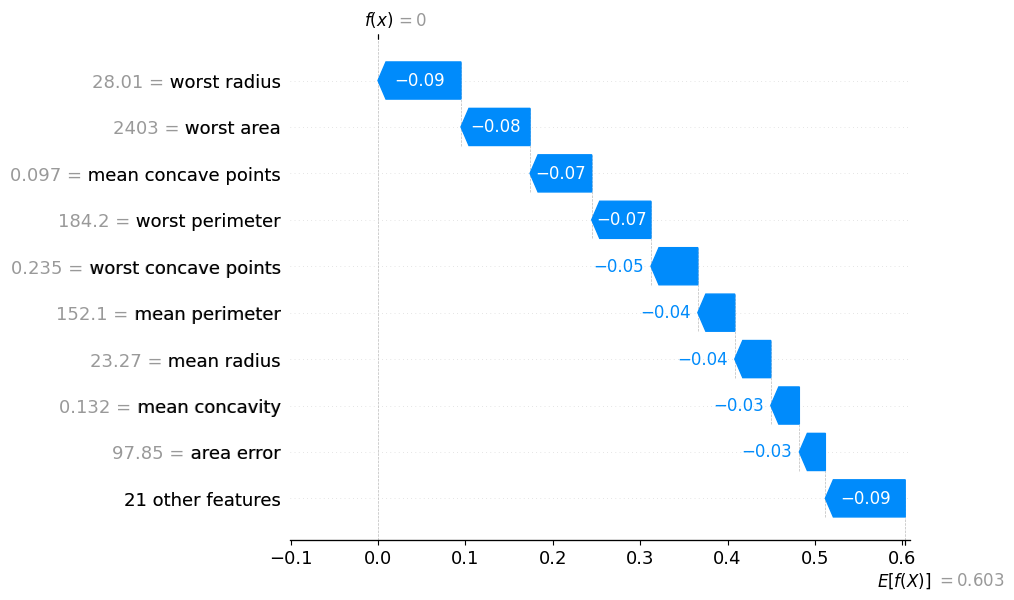

In [ ]:
shap.plots.waterfall(shap_values[1])

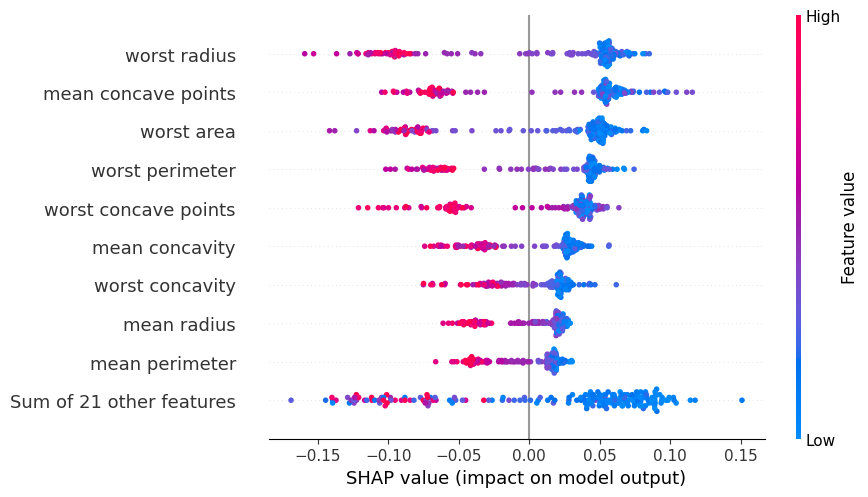

In [ ]:
shap.plots.beeswarm(shap_values)